Stiamo usando: cuda
Scaricamento dati in corso...
dati pronti caricati e normalizzati
3 immagini e maschere di esempio...


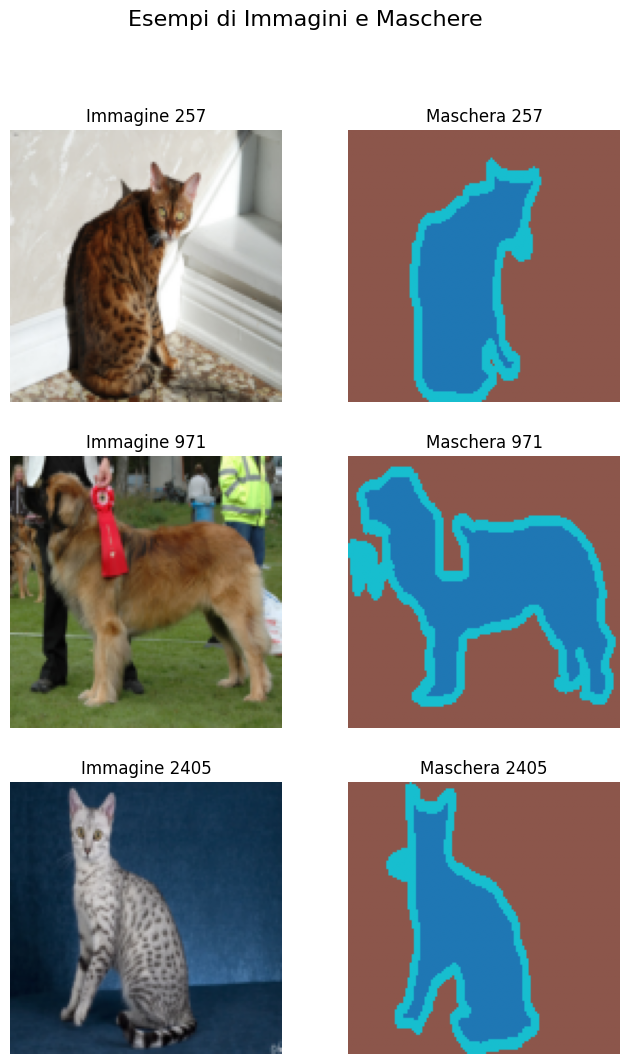

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random

# CONFIGURAZIONI
# Imposto la dimensione a 128x128  ed un batch_size adeguato per le performance disponibili utilizzando un Runtime T4 a GPU di COLAB
IMG_SIZE = 128
BATCH_SIZE = 16
LR = 0.001

# verifico che sia impostato CUDA per sfruttare la GPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Stiamo usando: {DEVICE}")

# ---------------------------------------------------------
# CARICAMENTO DEL DATASET Oxford-IIIT Pet
# ---------------------------------------------------------

# istanzio una pipeline per trasformare le immagini, faccio un resize alla dimensione predefinita e transformo in tensore PyTorch (normalizzando)
img_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# in modo simile, ma lavorando su maschere di segmentazione, creo una pipeline per le maschere
# stavolta devo modificare l'interpolazione e non usare la normalizzazione
mask_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor(),
])

# istanzio una classe che fa da adattatore, estendendo OxfordIIITPet
class OxfordPetDataset(datasets.OxfordIIITPet):
    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        # Le maschere originali hanno valori: 1 (animale), 2 (sfondo), 3 (bordo).
        # PyTorch prevede classi da 0, quindi sottraggo 1 agli elementi della maschera
        return img_transform(img), mask_transform(target) - 1

# utilizzando la nuova classe, scarico il dataset dividendo tra training e test
print("Scaricamento dati in corso...")
train_data = OxfordPetDataset(root='./data', split='trainval', target_types='segmentation', download=True)
test_data = OxfordPetDataset(root='./data', split='test', target_types='segmentation', download=True)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print("dati pronti caricati e normalizzati")

# Provo a visualizzare qualche immagine e maschera di esempio
print("3 immagini e maschere di esempio...")

fig, axes = plt.subplots(3, 2, figsize=(8, 12))
fig.suptitle('Esempi di Immagini e Maschere', fontsize=16)

for i in range(3):
    #  prendo delle immagini casuali dal dataset di training
    idx = random.randint(0, len(train_data) - 1)
    img, mask = train_data[idx]

    # avendo caricato le immagini come tensori [C, H, W], le devo riordinare le dimensioni per matplotlib [H, W, C]
    img_display = img.permute(1, 2, 0).numpy()
    # anche le maschere sono tensori [C, H, W], per visualizzarle uso il metodo squeeze [H, W]
    mask_display = mask.squeeze().numpy()

    axes[i, 0].imshow(img_display)
    axes[i, 0].set_title(f'Immagine {idx}')
    axes[i, 0].axis('off')

    # Per visualizzare le classi (0, 1, 2) della maschera uso una colormap
    axes[i, 1].imshow(mask_display, cmap='tab10', vmin=0, vmax=2)
    axes[i, 1].set_title(f'Maschera {idx}')
    axes[i, 1].axis('off')

plt.show()